# Introduction to Monte Carlo Methods

This notebook contains all the Python code in Chapter 4: Introduction to Monte Carlo Methods. Below, we shall explore how to implement Monte Carlo Methods for numerical integration and understand some of the most helpful sampling techniques in both MCMC and SMC algorithms.

**Index:**
* [Monte Carlo Integration](#monte-carlo-integration)
* [Importance Sampling](#importance-sampling)
* [Self Normalized Importance Sampling](#self-normalized-importance-sampling)
* [Importance Sampling Resampling](#importance-sampling-resampling)

In [177]:
#Import all the needed libraries
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns

## Monte Carlo Integration

Lets assume we are trying to approximate the solution for 
$$
\mathbb{E}_f[f(x)] = \int_0^1 [\cos(50x)+\sin(20x)]^2 dx
$$
where: 
$$
f(x)= [\cos(50x)+\sin(20x)]^2,
$$
and
$$
f(X)= 1, \quad X \sim U(0,1)
$$.

In [225]:
def MCI(h, f_samples, n):
    """Perform Monte Carlo Integration to estimate the expectation of f(x) using n samples drawn from f(X)

    Args:
        h (callable): The function f(x)to be integrated.
        f_samples (callable): n samples from the probability distribution f(X)
        n(int): # of samples
        
    Returns:
        estimate: estimate value of the expectation of f(x)using Monte Carlo Integration
    """
    
    values = h(f_samples)
    mu = np.sum(values)/n
    var = np.sum((values - mu)**2)
    std_error = np.sqrt(var) / n
        
    return mu, std_error

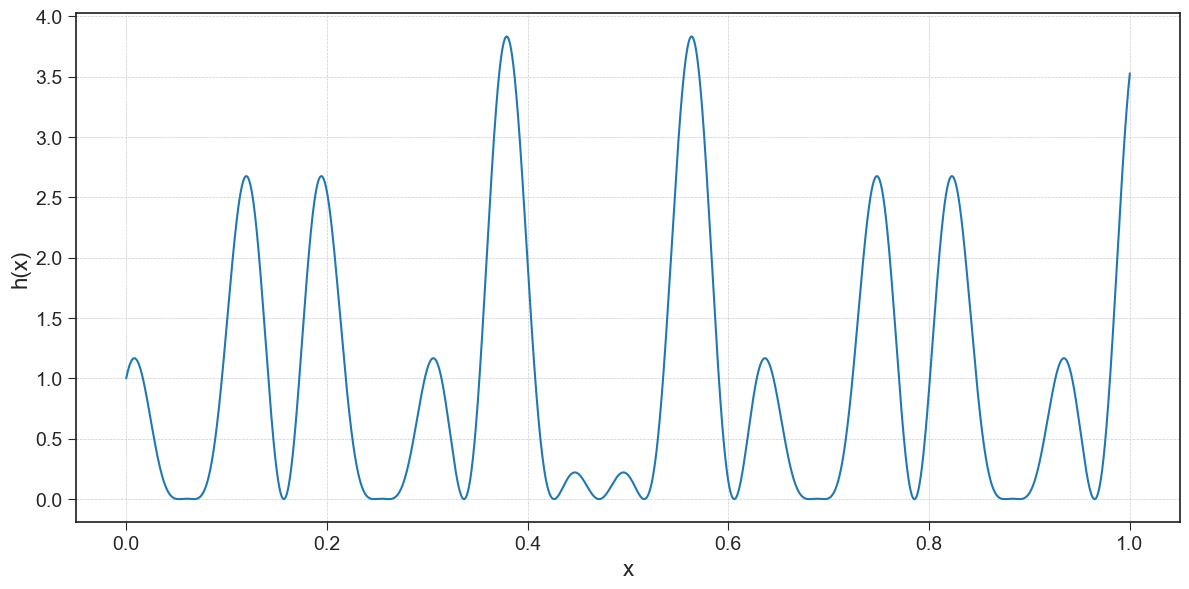

In [226]:
#Define and chart target function
def h_MC(x):
    return (np.cos(50*x) + np.sin(20*x))**2

x = np.linspace(0,1,10000)


plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(x,h_MC(x),color=colors[1] )
plt.xlabel('x', fontsize=16)
plt.ylabel('f(x)', fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [275]:
n_MCI = 10000
n_values_MCI = np.arange(1, n_MCI)
estimates_MCI = []
upper_bounds_MCI = []
lower_bounds_MCI = []
for k in n_values_MCI:
    f_MC = stats.uniform(0,1).rvs(k)
    mu_MCI, error_MCI = MCI(h_MC,f_MC, k)
        
    CI = 2*error_MCI
    upper_MCI = mu_MCI + CI
    lower_MCI = mu_MCI - CI
    
    estimates_MCI.append(mu_MCI)
    upper_bounds_MCI.append(upper_MCI)
    lower_bounds_MCI.append(lower_MCI)

np.float64(0.9317547469066815)

Result of integration: 0.9652009360501453
Estimated error: 1.8542214725442152e-10
Average of MC approximations: 0.9656627446322623


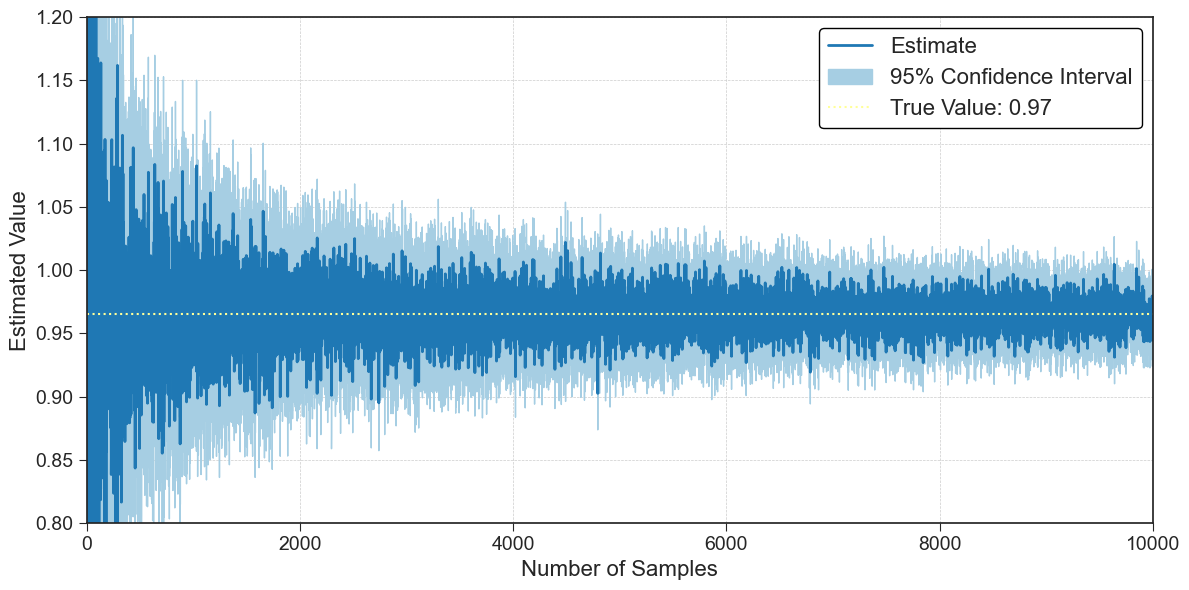

In [307]:
#Calculate exact result and compare with MC approximation
result_MCI, error_MCI2= quad(h_MC, 0, 1)

print("Result of integration:", result_MCI)
print("Estimated error:", error_MCI2)
print("Average of MC approximations:",np.mean(estimates_MCI))


# Plot the results
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(n_values_MCI, estimates_MCI, linewidth=2, color=colors[1], label='Estimate',)
plt.fill_between(n_values_MCI, lower_bounds_MCI, upper_bounds_MCI, color=colors[0], label='95% Confidence Interval')
plt.axhline(y=result_MCI, color=colors[10],linewidth=1.5, linestyle=':', label=f'True Value: {result_MCI:.2f}')


plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Estimated Value', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(0,n_MCI)
plt.ylim(0.8,1.2)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

## Importance Sampling

In this case, let us assume are trying to estimate 
$$
\mathbb{E}_f[f(x)] = \int_0^{10} e^{-2 |x-5|} dx = 10 \int_0^{10} \frac{1}{10} e^{-2 |x-5|} dx
$$
where we can conveniently define
* $f(x)= e^{-2 |x-5|}$,
* $f(x) = \frac{1}{10}$, $x \sim U(0,10)$

We can try to approximate this integral using basic Monte Carlo Integration, however, we can also rely on Importance Sampling and choose our importance function $g(x)$ as  
$$
g(X) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}(x-5)^2}, 
$$
to get a better approximation of the result.

In [319]:
#Define and chart target function
def IS(h,f,g, g_samples, n):
    """Perform Importance Sampling to estimate the expectation of f(x)*f(x) using n samples drawn from g(X)

    Args:
        h(callable): The function f(x)to be integrated.
        f(callable): The function f(x) to calculate the importance weights
        g(callable): The function g(x) to calculate the importance weights
        g_samples (callable): n samples from the probability distribution g(X)
        n(int): number of samples
        
    Returns:
        estimate: estimate value of the expectation of f(x)using Monte Carlo Integration
    """
    
    weights = f(g_samples) / g(g_samples)
    values = weights * h(g_samples)    
    
    mu = np.sum(values)/n
    var = np.sum((values - mu)**2)
    std_error = np.sqrt(var)/n
    
    return mu, std_error

In [337]:
x = stats.norm(loc=5, scale=1).rvs(1000)
h = np.exp(-2*np.abs(x-5))
g = stats.norm(loc=5, scale=1).pdf(x)
np.sum(0.1/g * 10*h)/1000

np.float64(0.9879602269311077)

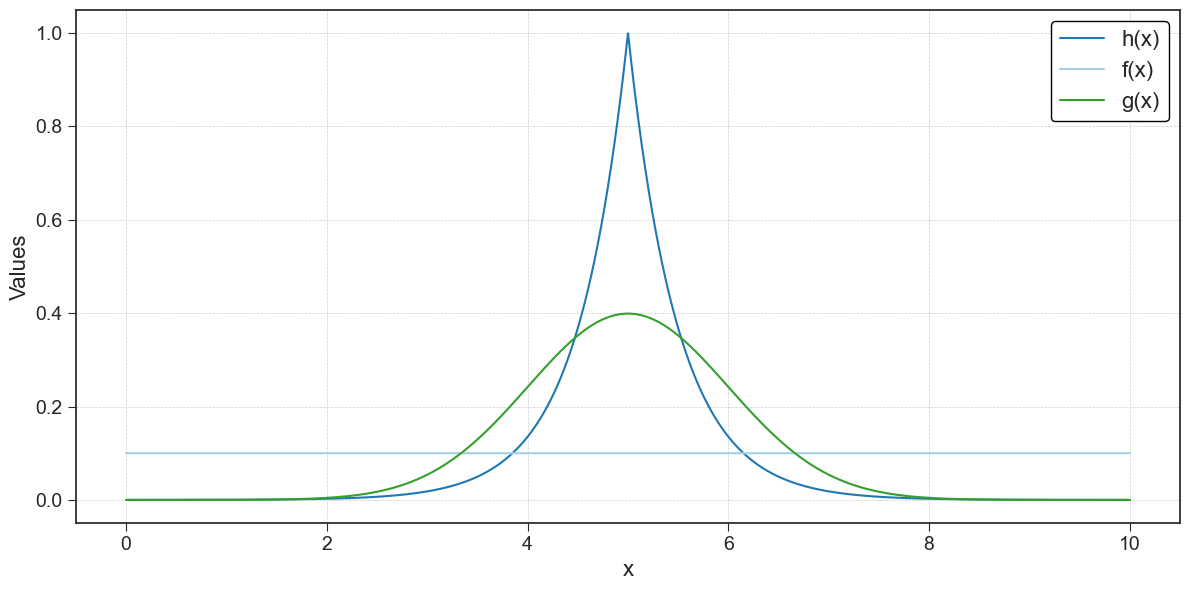

In [344]:
#Define the functions
def h_IS(x):
    return 10*np.exp(-2*np.abs(x-5))
def f_IS(x):
    return stats.uniform.pdf(x,loc=0,scale=10)
def g_IS(x):
    return stats.norm.pdf(x, loc=5, scale =1)

#Plot the functions
x = np.linspace(0,10,10000)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(x,np.exp(-2*np.abs(x-5)),color=colors[1], label = 'f(x)')
plt.plot(x,f_IS(x), color=colors[0], label = 'f(x)')
plt.plot(x,g_IS(x), color=colors[3], label='g(x)')

plt.xlabel('x', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(-0.5,10.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [345]:
n_IS = 1000
n_values_IS = np.arange(1, n_IS)

estimates_MC = []
upper_bounds_MC = []
lower_bounds_MC = []
estimates_IS = []
upper_bounds_IS = []
lower_bounds_IS = []

for k in n_values_IS:
    #Calculate MC approximation
    f_IS_Samples = stats.uniform(0,10).rvs(k)
    mu_MC, error_MC = MCI(h_IS,f_IS_Samples,k)

    CI_MC = 2*error_MC
    upper_MC = mu_MC + CI_MC
    lower_MC = mu_MC - CI_MC
    
    estimates_MC.append(mu_MC)
    upper_bounds_MC.append(upper_MC)
    lower_bounds_MC.append(lower_MC)
    
    #Calculate IS approximation
    g_IS_samples = stats.norm(5,1).rvs(k)
    mu_IS, error_IS = IS(h_IS,f_IS,g_IS,g_IS_samples,k)
    
    CI_IS = 2*error_IS
    upper_IS = mu_IS + CI_IS
    lower_IS = mu_IS - CI_IS
    
    estimates_IS.append(mu_IS)
    upper_bounds_IS.append(upper_IS)
    lower_bounds_IS.append(lower_IS)
    

Result of integration: 0.999954600070238
Estimated error: 2.8421709430404007e-13
Average of MCI approximations: 1.0010513529495337
Average of IS approximations: 1.0014609957124894


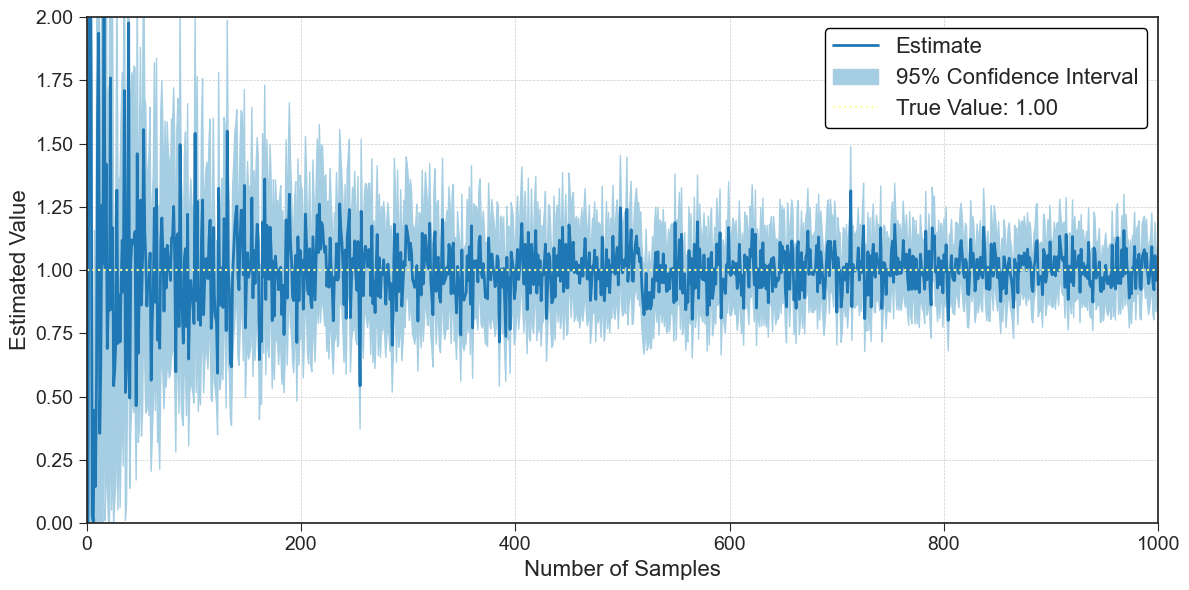

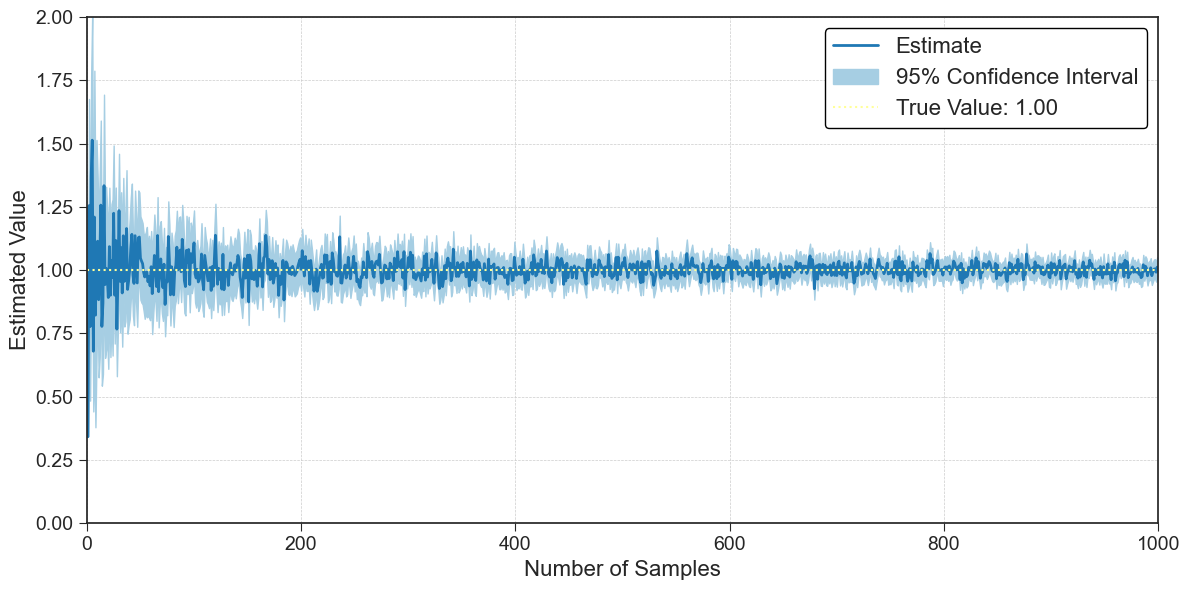

In [787]:
#Calculate exact result and compare with MX approximation
result_IS, error_IS2 = quad(h_IS, 0, 10)

print("Result of integration:", result_IS/10)
print("Estimated error:", error_IS2)
print("Average of MCI approximations:",np.mean(estimates_MC))
print("Average of IS approximations:",np.mean(estimates_IS))


# Plot MCI results
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(n_values_IS, estimates_MC, linewidth=2, color=colors[1], label='Estimate')
plt.fill_between(n_values_IS, lower_bounds_MC, upper_bounds_MC, color=colors[0], alpha=1, label='95% Confidence Interval')
plt.axhline(y=result_IS/10, color=colors[10], linewidth=1.5, linestyle=':', label=f'True Value: {result_IS/10:.2f}')

plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Estimated Value', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(0,n_IS)
plt.ylim(0,2)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()


# Plot IS results
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(n_values_IS, estimates_IS, linewidth=2, color=colors[1], label='Estimate')
plt.fill_between(n_values_IS, lower_bounds_IS, upper_bounds_IS, color=colors[0], label='95% Confidence Interval')
plt.axhline(y=result_IS/10, color=colors[10], linewidth=1.5, linestyle=':', label=f'True Value: {result_IS/10:.2f}')

plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Estimated Value', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(0,n_IS)
plt.ylim(0,2)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

## Self Normalized Importance Sampling

Lets assume we are trying to estimate the integral of 
$$
\int_0^\infty \frac{1}{Z} x^3 e^{-3x} dx, \quad x\geq 0,
$$
where we define $h(x) = x$ and $f(x) = \frac{1}{Z} x^2 e^{-3x}$ is a $\Gamma(3,3)$ distribution with normalization constant $Z = 2/27$ which we will asume to have forgotten.

Our goal is to use the SNIS algorithm to estimate the value of this integral and the value of $Z$ using the truncated normal $g(X) \sim N_{[0,\infty]}(1,1)$ as our importance sampling distribution. 

Since $Z = \int_0^\infty x^2 e^{-3x} dx$ if we define $f(x)= x^2 e^{-3x}$ we know that we can aproximate it using
\begin{align*}
Z &= \int_0^\infty f(x) dx = \int_0^\infty \frac{f(x)}{g(x)}g(x) dx = \int_0^\infty w(x)g(x)dx \approx \frac{1}{n} \sum_{i=1}^n w(x_i)
\end{align*}

Therefore
\begin{align*}
\int_0^\infty \frac{h(x)f(x)}{Z} dx &= \int_0^\infty \frac{h(x)f(x)g(x)/g(x)}{\int_0^\infty f(x)g(x)/g(x)dx}  dx = \int_0^\infty \frac{w(x)h(x)g(x)dx}{\int_0^\infty w(x)g(x)dx} \\
& \approx \sum_{i=1}^n \frac{w(x_i)h(x_i)}{\sum_{i=1}^n w(x_i)} = \sum_{i=1}^n \bar{w}(x_i)h(x_i)
\end{align*}

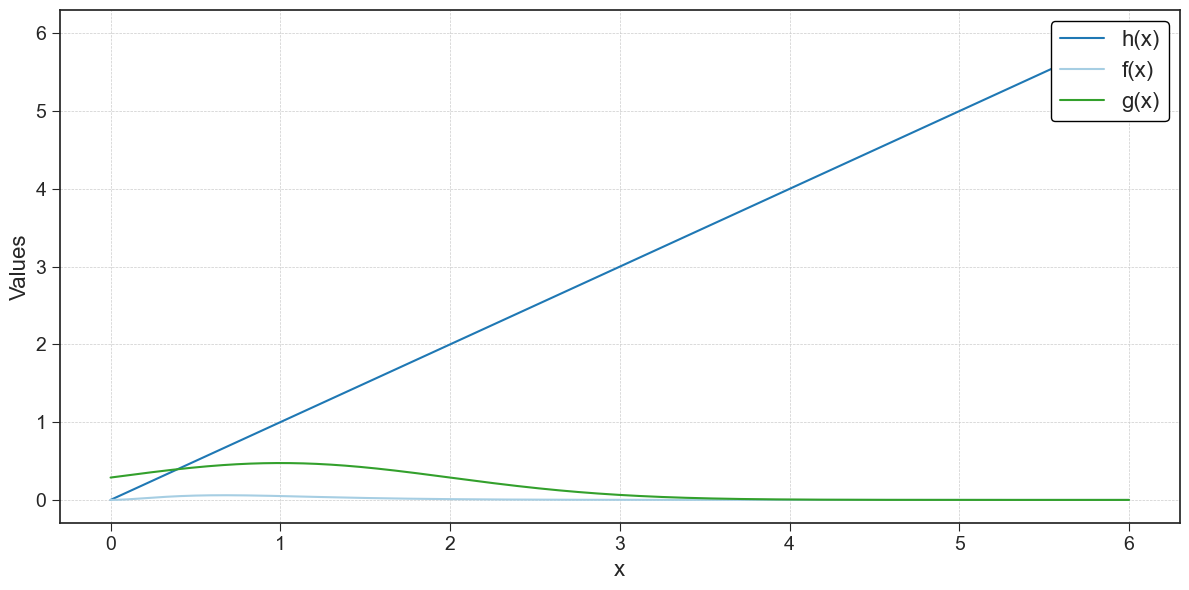

In [807]:
#Define the functions

def h_SNIS(x):
    return x #np.ones_like(x)

def f_SNIS(x):
    return x**2 * np.exp(-3*x)

def g_SNIS(x):
    return stats.truncnorm(a=-1, b=np.inf, loc=1, scale=1).pdf(x)


#Plot the functions
x = np.linspace(0,6,1000)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(x,h_SNIS(x), color=colors[1], label = 'h(x)')
plt.plot(x,f_SNIS(x), color=colors[0], label = 'f(x)')
plt.plot(x,g_SNIS(x), color=colors[3], label='g(x)')

plt.xlabel('x', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [808]:
#Define and chart target function
def SNIS(h,f,g, g_samples, n):
    """Perform Importance Sampling to estimate the expectation of f(x)*f(x) using n samples drawn from g(X)

    Args:
        h(callable): The function f(x) to be integrated.
        f(callable): The function f(x) to calculate the importance weights
        g(callable): The function g(x) to calculate the importance weights
        g_samples (callable): n samples from the probability distribution g(X)
        n(int): number of samples
        
    Returns:
        estimate: estimate value of the expectation of f(x) using Monte Carlo Integration
    """
    
    weights = f(g_samples) / g(g_samples)
    w_sum = weights.sum()
    normalized_w = weights / w_sum
    Z = w_sum/n
    Z_var = np.sum((weights-Z)**2)
    Z_error = np.sqrt(Z_var)/n
    
    h_values = h(g_samples)
    values = normalized_w * h_values  
    mu = np.sum(values)
    
    var = np.sum(normalized_w**2*(h_values - mu)**2)
    std_error = np.sqrt(var)
    
    ESS = 1 / (normalized_w**2).sum()
    
    
    return mu, std_error, ESS, Z, Z_error

In [809]:
n_SNIS = 1000
n_values_SNIS = np.arange(1, n_SNIS)

estimates_SNIS = []
upper_bounds_SNIS = []
lower_bounds_SNIS = []
ESS_SNIS = []

Z_SNIS = []
Z_upper_bounds_SNIS = []
Z_lower_bounds_SNIS = []

for k in n_values_SNIS:
    samples = stats.truncnorm(a=-1, b=np.inf, loc=1, scale=1).rvs(k)
    mu, error, ESS, Z, Z_error = SNIS(h_SNIS,f_SNIS,g_SNIS, samples, k)
    
    CI = 2 * error
    upper_SNIS = mu + CI
    lower_SNIS = mu - CI
    
    estimates_SNIS.append(mu)
    upper_bounds_SNIS.append(lower_SNIS)
    lower_bounds_SNIS.append(upper_SNIS)
    ESS_SNIS.append(ESS)
    
    Z_CI = 2 * Z_error
    Z_upper_SNIS = Z + Z_CI
    Z_lower_SNIS = Z - Z_CI
    
    Z_SNIS.append(Z)
    Z_upper_bounds_SNIS.append(Z_upper_SNIS)
    Z_lower_bounds_SNIS.append(Z_lower_SNIS)

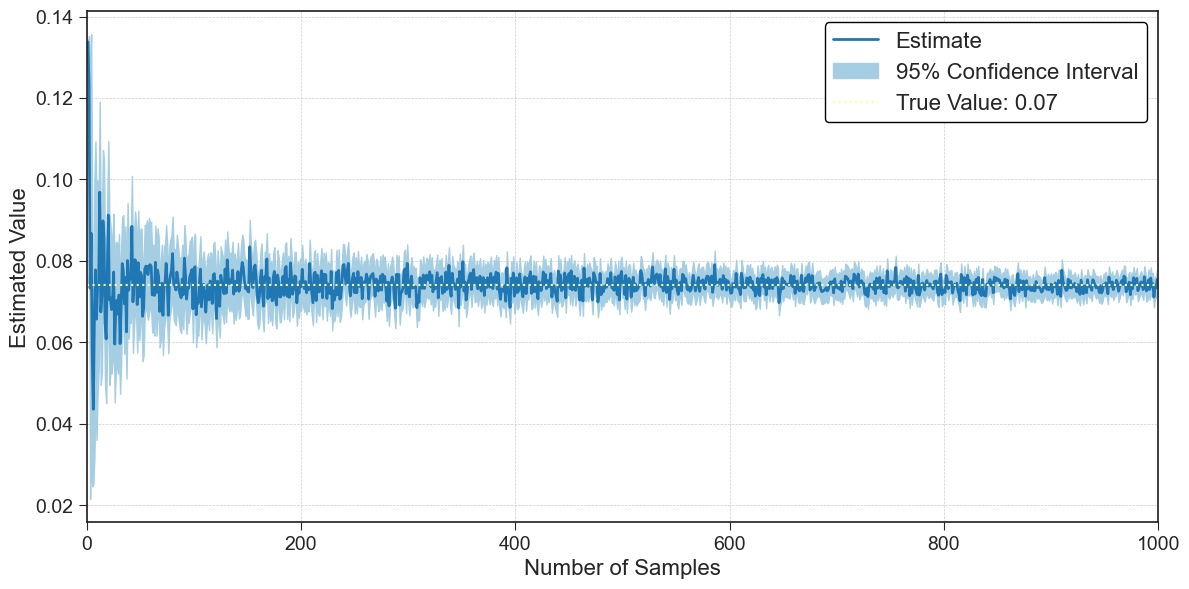

In [810]:
# Plot SNIS results
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(n_values_SNIS, Z_SNIS,  linewidth=2, color=colors[1], label='Estimate')
plt.fill_between(n_values_SNIS, Z_lower_bounds_SNIS, Z_upper_bounds_SNIS, color=colors[0], label='95% Confidence Interval')
plt.axhline(y=2/27, color=colors[10], linewidth=1.5, linestyle=':', label=f'True Value: {2/27:.2f}')

plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Estimated Value', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(0,n_SNIS)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

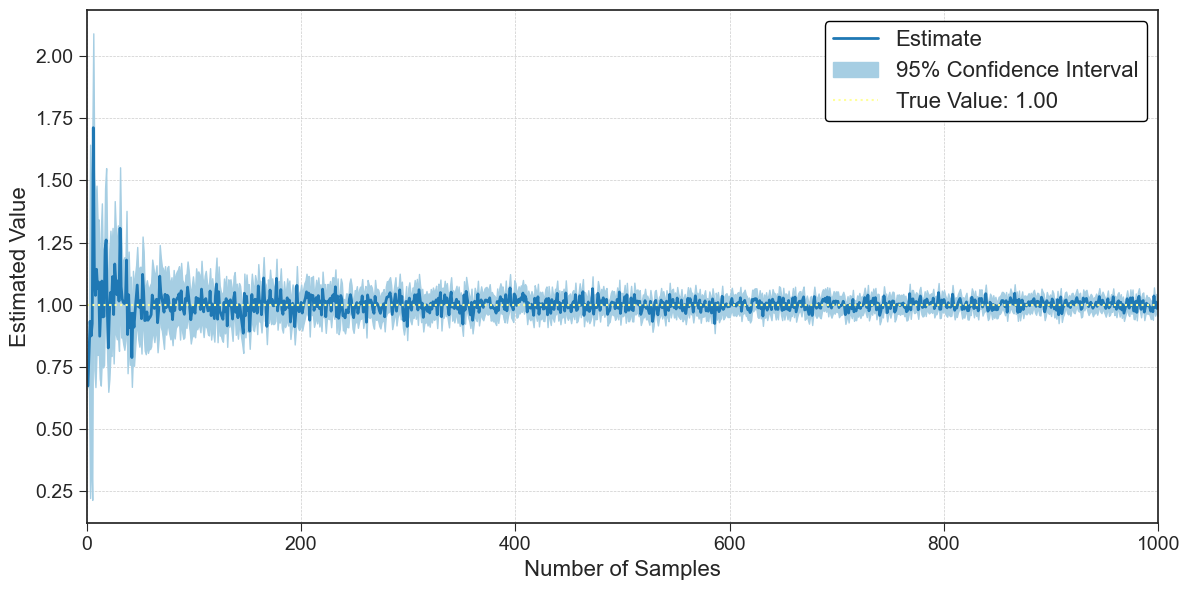

In [811]:
# Plot SNIS results
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(n_values_SNIS, estimates_SNIS,  linewidth=2, color=colors[1], label='Estimate')
plt.fill_between(n_values_SNIS, lower_bounds_SNIS, upper_bounds_SNIS, color=colors[0], label='95% Confidence Interval')
plt.axhline(y=1, color=colors[10], linewidth=1.5, linestyle=':', label=f'True Value: {1:.2f}')

plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Estimated Value', fontsize=16)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlim(0,n_SNIS)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

# Importance Sampling Resampling

Suppose we have the following probability distribution functions, $f \sim \chi^2(5)$ and $g \sim \exp(1)$, where $f$ is not the normalized distribution.

We cant to employ the Importance Sampling Resamplig algorythm to sample from $f$.


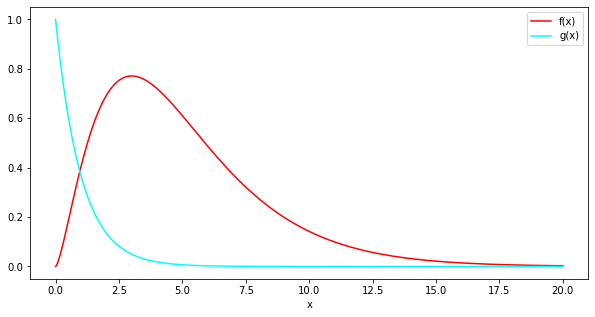

In [3]:
#Defiine the functions:
def f(x):
    return 5*stats.chi2(5).pdf(x)

def g(x):
    return stats.expon().pdf(x)

#Plot the functions:
x = np.linspace(0,20,1000)

plt.figure(figsize=(10, 5))
plt.plot(x,f(x), color='red', label = 'f(x)')
plt.plot(x,g(x), color='cyan', label='g(x)')
plt.legend()
plt.xlabel('x')
plt.show()

In [11]:
#SIR algorithm
n = 1000000

samples = stats.expon().rvs(n)

weights = f(samples) / g(samples)
Z = weights.sum(0)

norm_w = weights / Z

print(weights.mean())

offsprings = np.random.multinomial(n,norm_w)

indices = np.arange(len(norm_w))  
new_samples = np.repeat(samples[indices], offsprings)  # Repeat each index according to its count



4.938048956266644


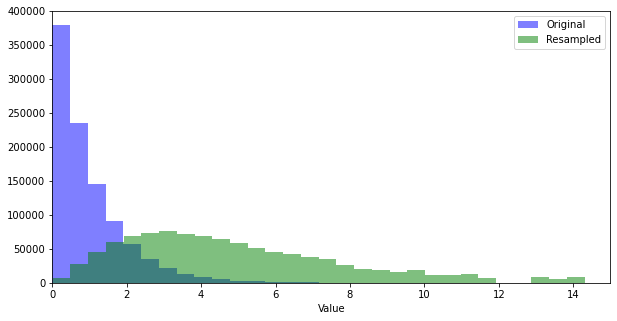

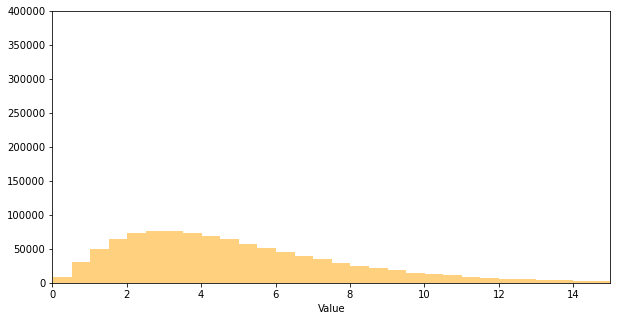

In [13]:
plt.figure(figsize=(10, 5))

plt.hist(samples, bins=30, alpha=0.5, color='blue', label='Original')
plt.hist(new_samples, bins=30, alpha=0.5, color='green', label='Resampled')

plt.xlabel('Value')
plt.legend()
plt.xlim(0,15)
plt.ylim(0,400000)

plt.show()

samples_f = stats.chi2(5).rvs(n)
plt.figure(figsize=(10, 5))
plt.hist(samples_f[samples_f<15], bins=30, alpha=0.5, color='orange')

plt.xlabel('Value')
plt.xlim(0,15)
plt.ylim(0,400000)
plt.show()